# XPCS Analysis using PyXPCS

In [2]:
%load_ext autoreload
%autoreload

import numpy as np

# File reader 
from pyxpcs.reader import IMMReader8ID

# Configuration classes for loading metadata from HDF5 file
from pyxpcs.config import PyXPCSDict
from pyxpcs.utils import config_from_8idhdf5, load_results

# Simple visualization.
from pyxpcs.viz import plot_pix_sum, plot_as_image

# Computation function
from pyxpcs.algorithms import to_sparse_matrix, multitau

import matplotlib.pyplot as plt

#from libpyxpcs import sparse_lil_index_value

from pprint import pprint

import os.path
import h5py
import matplotlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Input Data

Specify the input IMM file to use. The result file from the xpcs-eigen analysis that contains G2, IP, and IF. The HDF5 file that will be used to run the pyxpcs analysis.

In [3]:
IMM_FILE =  "/Users/jeffr/Desktop/H432_OH_100_025C_att05_001/H432_OH_100_025C_att05_001_00001-01000.imm"
HDF5_FILE = "/Users/jeffr/Desktop/H432_OH_100_025C_att05_001/H432_OH_100_025C_att05_001_0001-1000.hdf"
QMAP_FILE = "/Users/jeffr/Desktop/H432_OH_100_025C_att05_001/jaeger202106_Lq0_S360_D36.h5"

#HDF5_FILE = "/home/8ididata/2021-2/jaeger202106/cluster_results/H432_OH_100_025C_att05_001_0001-1000.hdf"

print("Check if imm file exists:", os.path.isfile(IMM_FILE))
print("Check if hdf5 file exists:", os.path.isfile(HDF5_FILE))
print("Check if qmap file exists:", os.path.isfile(QMAP_FILE))



Check if imm file exists: True
Check if hdf5 file exists: True
Check if qmap file exists: True


In [3]:
#ls /net/wolf/data/xpcs8/2021-2/jaeger202106/cluster_results/H432_*


/net/wolf/data/xpcs8/2021-2/jaeger202106/cluster_results/H432_OH_100_025C_att05_001_0001-1000.hdf
/net/wolf/data/xpcs8/2021-2/jaeger202106/cluster_results/H432_OH_100_025C_att05_001_0001-1000_Twotime.hdf


## Configuration

Load the configuration that are specific to 8-ID-I


In [4]:
# config = config_from_8idhdf5(HDF5_FILE)
# try:
#     import pandas as pd
#     df = pd.DataFrame.from_dict(config, orient='index')
#     print(df)
# except:
#     pass

config = {}

with h5py.File(HDF5_FILE, 'r') as f1:

    config['frames'] = np.squeeze(f1.get('/measurement/instrument/acquisition/data_end')[()])
    config['rows'] = np.squeeze(f1.get('/measurement/instrument/detector/x_dimension')[()])
    config['cols'] = np.squeeze(f1.get('/measurement/instrument/detector/y_dimension')[()])
    config['pixels'] = config['rows']*config['cols']
    config['beam_center_x'] = np.squeeze(f1.get('/measurement/instrument/acquisition/beam_center_x')[()])
    config['beam_center_y'] = np.squeeze(f1.get('/measurement/instrument/acquisition/beam_center_y')[()])
    config['detector_distance'] = np.squeeze(f1.get('/measurement/instrument/detector/distance')[()])
    config['pixel_size'] = np.squeeze(f1.get('/measurement/instrument/detector/x_pixel_size')[()])
    config['x_energy'] = np.squeeze(f1.get('/measurement/instrument/source_begin/energy')[()])
    config['delays_per_level'] = 4  # This number will be specified by the user as input


with h5py.File(QMAP_FILE, 'r') as f2:

    config['sqmap'] = np.squeeze(f2.get('/data/staticMap')[()])
    config['dqmap'] = np.squeeze(f2.get('/data/dynamicMap')[()])  
    
try:
    import pandas as pd
    df = pd.DataFrame.from_dict(config, orient='index')
    print(df)
except:
    pass


                                                                   0
frames                                                          1000
rows                                                            1556
cols                                                             516
pixels                                                        802896
beam_center_x                                                  778.8
beam_center_y                                                  257.8
detector_distance                                             7800.0
pixel_size                                                     0.055
x_energy                                                      10.945
delays_per_level                                                   4
sqmap              [[360, 360, 360, 359, 359, 358, 358, 357, 357,...
dqmap              [[36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, ...


C:\Users\jeffr\Anaconda3\lib\site-packages\pandas\core\internals\construction.py:312: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [5]:
# mask = config['dqmap'].flatten()
# mask

# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# im = ax.imshow(config['dqmap'], cmap='jet')


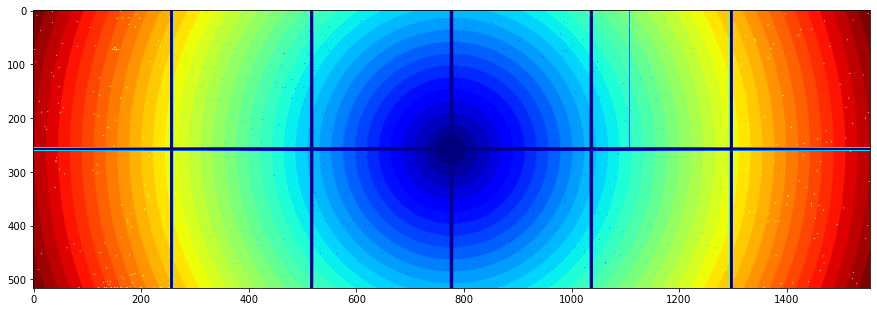

In [6]:
# qmap_path = '/home/8-id-i/partitionMapLibrary/2021-1'
# qmap_name = 'jaeger202102_Lq0_S360_D36_Lin.h5'

# with h5py.File(os.path.join(qmap_path, qmap_name), 'r') as f:
#     _ = f['data']['dynamicMap'][:]
# mask = _.flatten()

mask = config['dqmap'].flatten()

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
im = ax.imshow(config['dqmap'], cmap='jet')


## Load data


In [7]:
reader = IMMReader8ID(IMM_FILE)

# Get the data read from the reader
indices, values = reader.data()
sparse_matrix = sparse_lil_index_value(indices, values, config['pixels'], mask)

## Plotting

Basic plotting to verify the data is read properly.

/home/beams10/8IDIUSER/pyxpcs/src/pyxpcs/viz.py:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  colormap.set_under(color='w')


<AxesSubplot:>

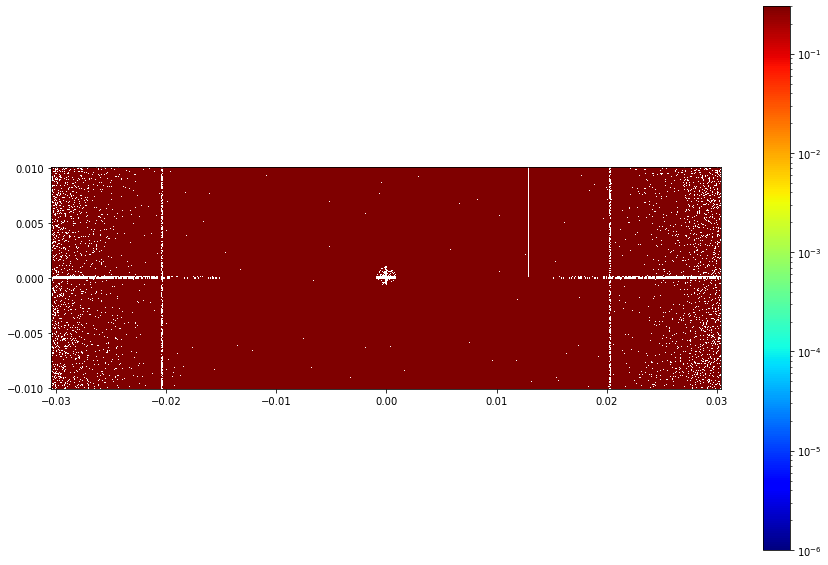

In [8]:
pixel_sum = np.zeros(config['cols'] * config['rows'])
for idx in range(len(indices)):
    pixel_sum[indices[idx]] += values[idx]

pixel_sum = np.reshape(pixel_sum, (config['cols'], config['rows']))
plot_pix_sum(pixel_sum, config)

## Analysis


### Sparse Matrix

Organized as list of list representations of sparse matrix. 


intensities = $$(f_5, f_4, \dots, f_{200}), (f_9, f_10, \dots, f_{150}) $$ 
indices = $$ (I_a, I_b) $$ 


As we are computing corelation that involves multiplying difference intensity values at a source index, and source + tau (step) index, we look them up using binaray search in the intensities array to speed up the computation. 

$$src\_index = i$$
$$dst\_index = i + tau$$

if dst_index found in binary_search(intensities):
    $$ G2(I_a, tau) += f_{src\_index} * f_{dst\_index}$$

In [9]:
mini_config = {
    'frames': config['frames'] if 'frames' in config else reader.frames_read,
    'pixels': config['cols'] * config['rows'],
    'delays_per_level': config['delays_per_level'] if 'delays_per_level' in config else 4,
    'rows': config['rows'],
    'cols': config['cols'],  
}

In [10]:
G2, IP, IF = multitau(sparse_matrix, config)

/home/beams10/8IDIUSER/pyxpcs/src/pyxpcs/viz.py:40: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  colormap.set_under(color='w')


<AxesSubplot:>

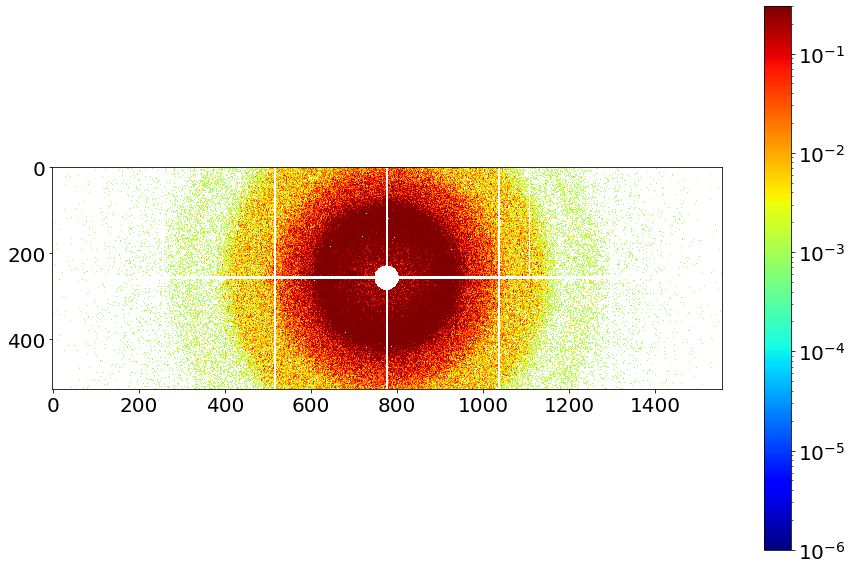

In [11]:
# In order to plot G2.
G2_plot = G2[0].reshape(config['cols'], config['rows'])
plot_as_image(G2_plot)

<AxesSubplot:>

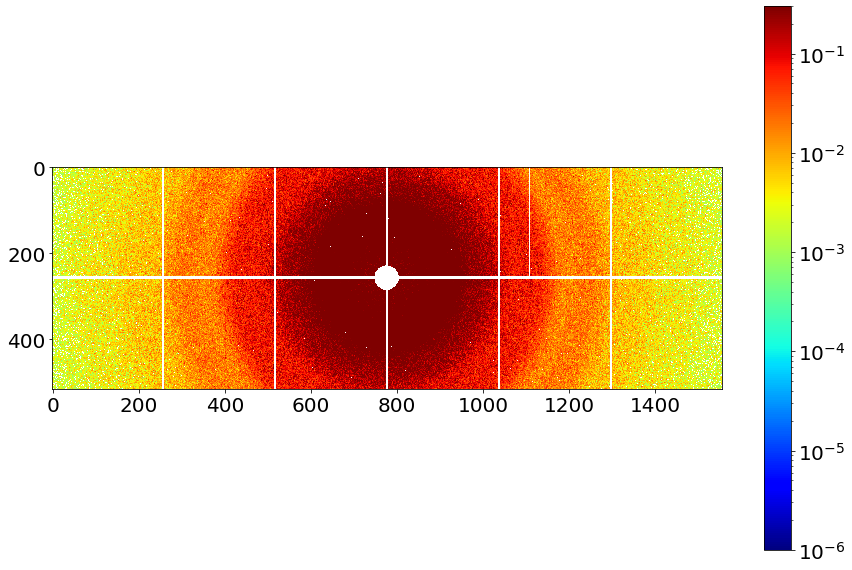

In [12]:
IP_plot = IP[0].reshape(config['cols'], config['rows'])
plot_as_image(IP_plot)

<AxesSubplot:>

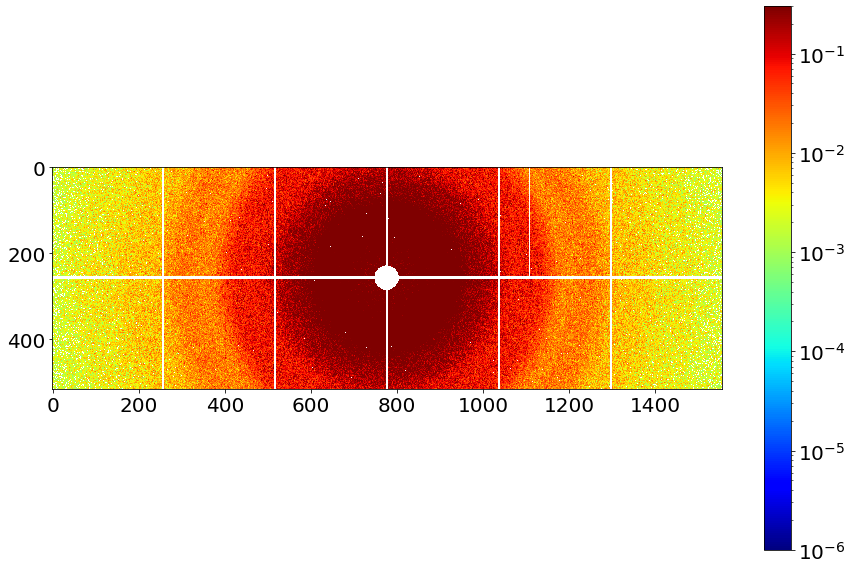

In [13]:
IF_plot = IF[0].reshape(config['cols'], config['rows'])
plot_as_image(IF_plot)

### g2 stderror

In [14]:
def compute_g2(G2, IP, IF, config):

    taus, pixels = G2.shape

    total_static_partitions = np.max(config['sqmap'])
    total_dynamic_partitions = np.max(config['dqmap'])
    
    # Final results
    g2 = np.zeros((taus, total_dynamic_partitions))
    g2_error = np.zeros((taus, total_dynamic_partitions))

    g2Sums = np.zeros((taus, total_static_partitions))
    ipSums = np.zeros((taus, total_static_partitions))
    ifSums = np.zeros((taus, total_static_partitions))

    dqmap = config['dqmap']
    sqmap = config['sqmap']


    IP_IF = IP * IF
    normalizedG2 = G2 /  (np.where( IP_IF != 0, IP_IF, 10000))

    # sum pixels for each static partitions
    for i in range(total_static_partitions):
        idx = (sqmap == i+1)
        g2Sums[:, i] = np.mean(G2[:, idx.flatten()], axis=1)
        ipSums[:, i] = np.mean(IP[:, idx.flatten()], axis=1)
        ifSums[:, i] = np.mean(IF[:, idx.flatten()], axis=1)

    ip_if_sums = ipSums * ifSums

    # Compute G2 error. 
    for i in range(total_dynamic_partitions):
        idx = (dqmap == i + 1)
        idx = idx.flatten()
        g2_error[:, i] = np.std(normalizedG2[:, idx], axis=1) / np.sqrt(pixels)

    for i in range(total_dynamic_partitions):
        low, high = np.amin(sqmap[dqmap == i+1]), np.max(sqmap[dqmap == i+1])
        tmp_g2_sum = g2Sums[:, low-1:high-1]
        g2[:, i] = np.mean(tmp_g2_sum / ip_if_sums[:, low-1:high-1], axis=1)
    
    return g2, g2_error

In [15]:
g2, g2_error = compute_g2(G2, IP, IF, config)

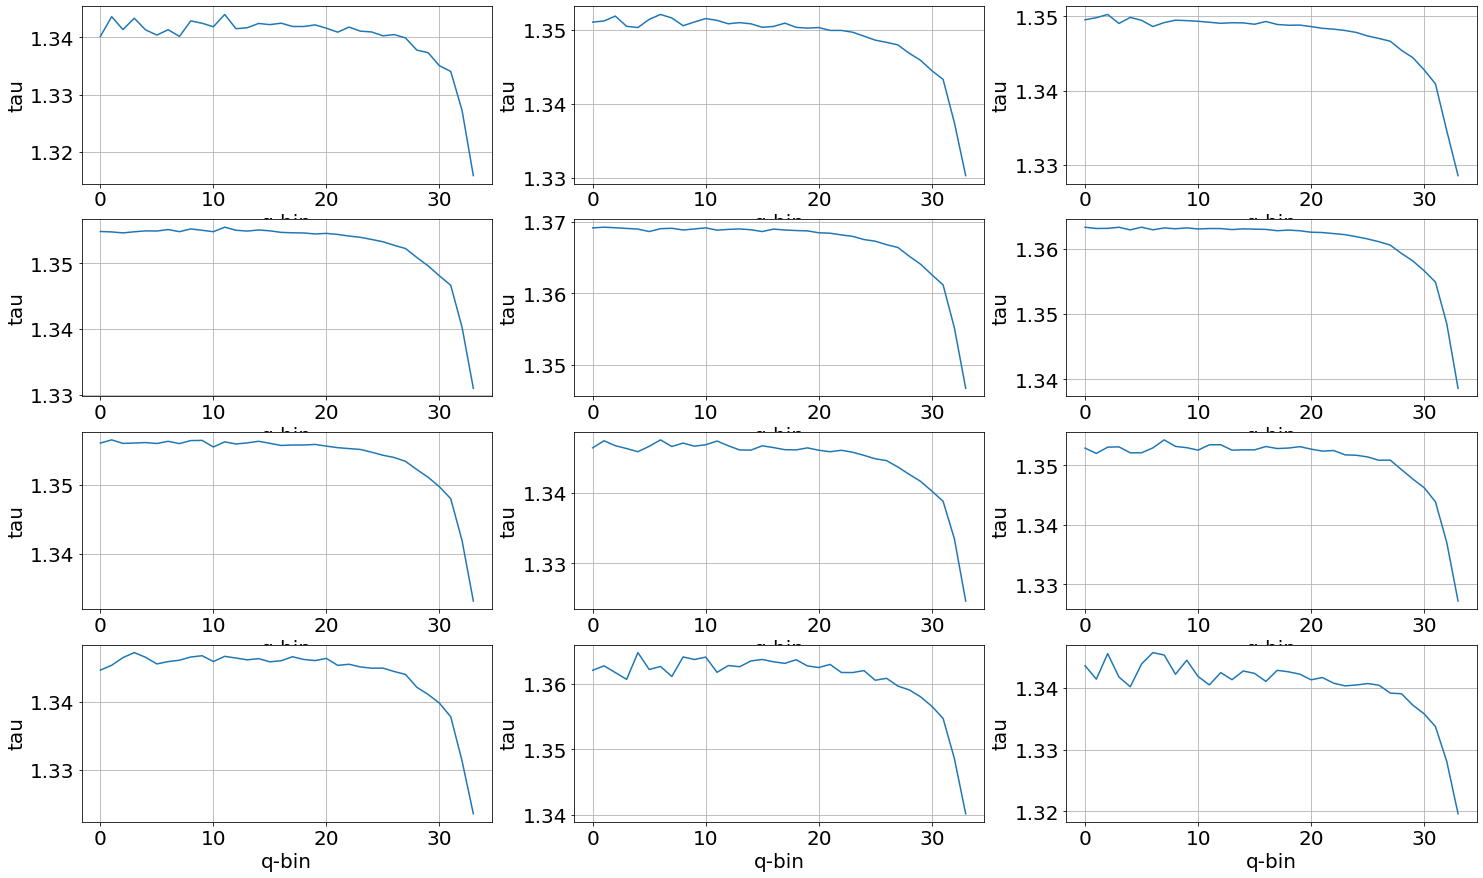

In [16]:
fig, m_axs = plt.subplots(4, 3, figsize=(25, 15))
[c_ax for c_ax in m_axs.flatten()]
idx = 0
for ax in m_axs:
    for ax2 in ax:
        ax2.plot(g2[:, idx])  
        ax2.set_xlabel('q-bin')
        ax2.set_ylabel('tau')
        ax2.grid(True)

        idx += 1